In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import dates as mpl_dates

In [2]:
df = pd.read_csv('data/cleaned_data', parse_dates = ['date'], 
                   index_col = 'date', dtype = {'subject_age': 'category', 'officer_gender':'category', 
                    'officer_race': 'category', 'subject_race':'category', 
                    'subject_gender':'category','arrest':'category', 
                    'frisk':'category'})
df.sort_index(inplace = True)
df['count'] = 1
df

,subject_age,stop_resolution,weapon_type,officer_age,officer_gender,officer_race,subject_race,subject_gender,initial_call_type,call_type,arrest,frisk,count
date,,,,,,,,,,,,,
2015-03-16,18 - 25,Field Contact,None,38,M,White,White,Male,NaN,NaN,N,N,1
2015-03-16,18 - 25,Arrest,None,31,M,White,Black or African American,Male,NaN,NaN,N,N,1
2015-03-16,36 - 45,Field Contact,None,38,M,White,Multi-Racial,Male,NaN,NaN,N,N,1
2015-03-17,26 - 35,Field Contact,None,38,M,White,White,Male,NaN,NaN,N,N,1
2015-03-17,26 - 35,Offense Report,None,31,M,White,White,Male,THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING),911,N,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-02,36 - 45,Field Contact,NaN,26,M,White,White,Male,TRESPASS,911,N,N,1
2021-09-03,36 - 45,Field Contact,NaN,35,M,White,Black or African American,Male,TRESPASS,ONVIEW,N,N,1
2021-09-03,46 - 55,Arrest,NaN,28,M,White,Black or African American,Female,ROBBERY (INCLUDES STRONG ARM),ONVIEW,Y,N,1


## What is the overall trend of Terry Stops since 2014?

In [69]:
df_date = df.copy()
df_date = df.loc['2015-04-01':'2021-09-01']
df_date = df['count'].resample('M').count()

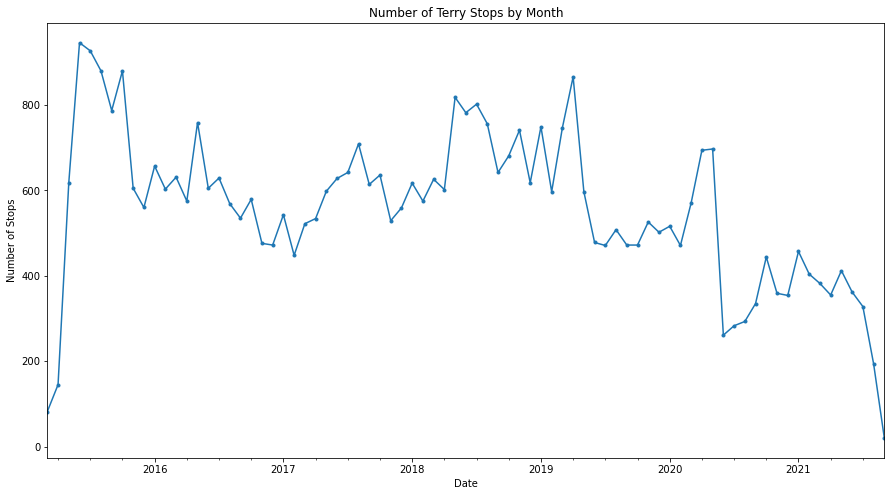

In [70]:
df_date.plot(marker = '.', linestyle = None, figsize = (15, 8))
plt.title('Number of Terry Stops by Month')
plt.xlabel('Date')
plt.ylabel('Number of Stops');

C:\Users\letru\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-78-554fa6f8286e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax = ax.set_xticklabels(dates)


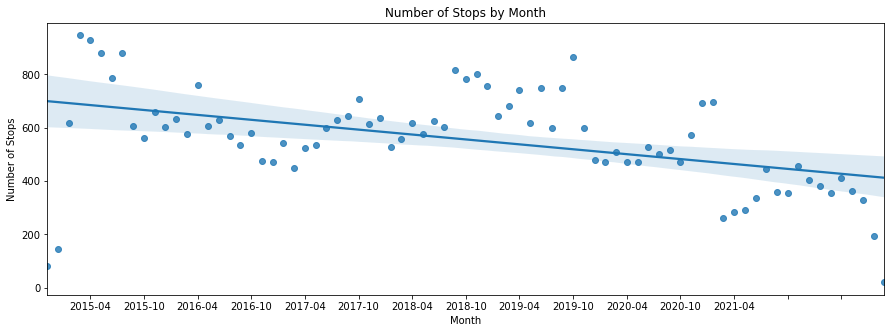

In [78]:
#import ticker to help with date visualization formatting
import matplotlib.ticker as ticker

# set x and y values for the seaborn plot
y = df_date.values
x = np.linspace(1, len(y), num = len(y))

plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
p = sns.regplot(x , y)

#format x axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
dates = pd.date_range(start= '2014-10', end = '2021-09', freq = '6M')
dates = [d.strftime('%Y-%m') for d in dates]
ax = ax.set_xticklabels(dates)


plt.title('Number of Stops by Month')
plt.xlabel('Month')
plt.ylabel('Number of Stops');

Overall, number of terry stops have been decreasing since 2014. There is a large increase tend decreased from start of data then started increasing gradually from 2017 - 2018 and remained steady. Decreased significantly at the start of the pandemic then increased again during around the time of BLM protests. Then dropping as more movements increased to defund the police. 

## What are the racial differences between terry stops?

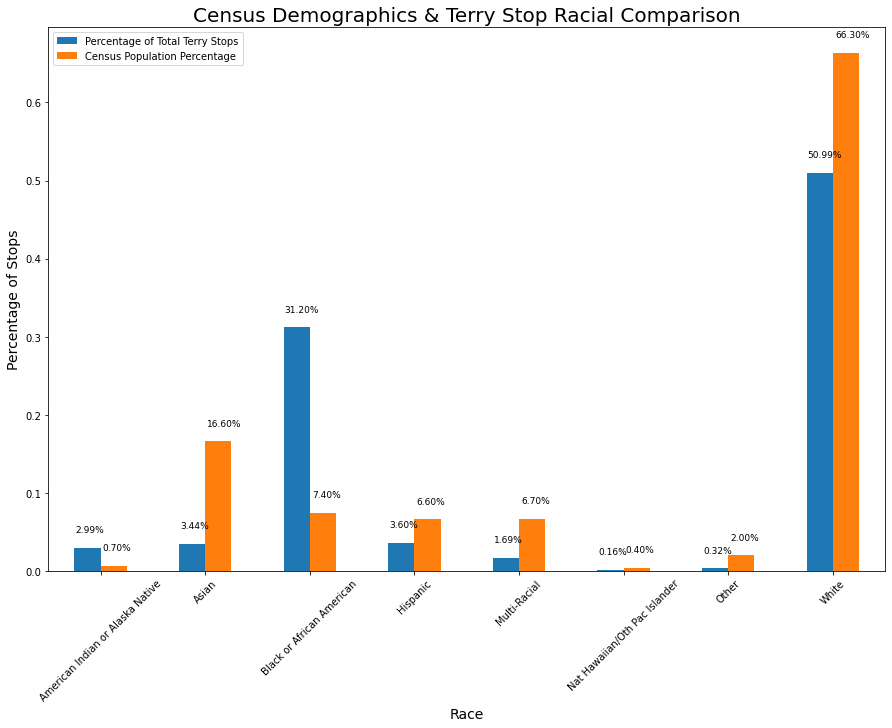

In [66]:
rp = df[['subject_race','count']]
rp = rp.groupby('subject_race').count()
rp['stop_pct'] = rp['count'] / rp['count'].sum()
rp.drop(['count'], axis = 1, inplace = True)

#create dataframe with census data information & join with main information
#info taken from Census page on Seattle.gov
census_data = pd.DataFrame(index = rp.index, data = {'census_pct' : [.007,.166,.074,.066,.067,.004,.02,.019,.663]} )
rp = rp.join(census_data)
rp = rp[rp.index != 'Unknown']

#plot the data
ax = rp.plot(kind = 'bar', figsize = (15,10))

#display the values over the corresoponding bar graphs
for i, v in enumerate(rp.stop_pct):
    ax.text(i-.24, v+.02, '{:.2f}%'.format(100*v),fontsize = 9)

for i, v in enumerate(rp.census_pct):
    ax.text(i+.02, v+.02, '{:.2f}%'.format(100*v),fontsize = 9)

plt.title('Census Demographics & Terry Stop Racial Comparison', fontsize = 20)
plt.xlabel('Race', fontsize = 14)
plt.ylabel('Percentage of Stops', fontsize = 14)
plt.legend(loc = 'best', labels = ['Percentage of Total Terry Stops', 'Census Population Percentage'] )
plt.xticks(rotation = 45)
plt.show()

Black residents are only 7% of the population but make up for 31% of the number of terry stops. Significantly higher ratio than any other race. For example, white residents make up for 66% of the population but account for 50% of the number of terry stops. Asian residents double the number of Black residents but are 10x less likely to be stopped. 

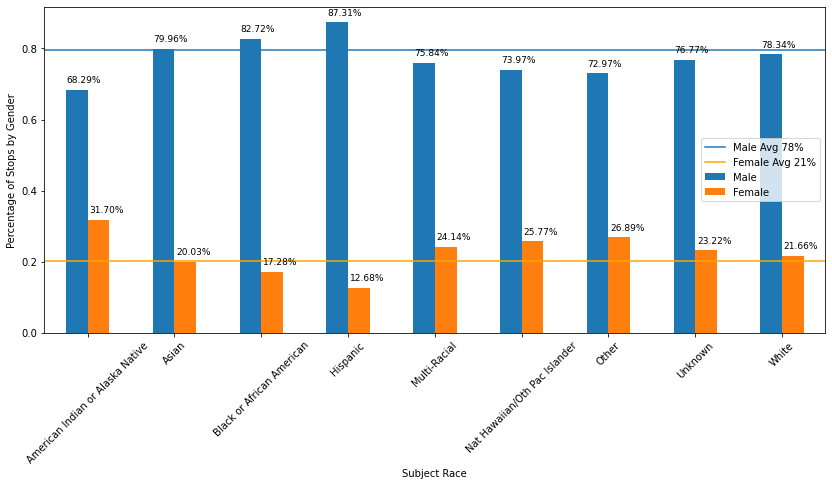

In [67]:
#subset the data & transform with pivot
tmp = df[['subject_gender', 'subject_race','count']]
tmp = tmp.groupby(['subject_race','subject_gender']).count()
tmp = tmp.pivot_table(index = 'subject_race', columns = 'subject_gender', values = 'count')

#add a new categories for additional columns
tmp.columns = tmp.columns.add_categories(['pct_male'])
tmp.columns = tmp.columns.add_categories(['pct_female'])

#add new columns with the percentage of male & female
tmp['pct_male'] = tmp.Male / tmp.sum(axis =1)
tmp['pct_female'] = tmp.Female / tmp.sum(axis =1)

male_avg = tmp.Male.sum(axis = 0) / (tmp.Male.sum(axis = 0) + 
                                     tmp.Female.sum(axis = 0).sum(axis = 0))

female_avg = tmp.Female.sum(axis = 0) / (tmp.Male.sum(axis = 0) + 
                                     tmp.Female.sum(axis = 0).sum(axis = 0))

tmp.drop(['Female', 'Male'], axis = 1, inplace = True) #drop original gender data

#plot the data
ax = tmp.plot(kind = 'bar',figsize = (14,6) )

#generate & plot the text value over each bar in the graph
for i, v in enumerate(tmp.pct_male):
    ax.text(i-.24, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

for i, v in enumerate(tmp.pct_female):
    ax.text(i+.02, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

plt.xticks(rotation = 45)
plt.axhline(male_avg)
plt.axhline(female_avg, color = 'orange', )

#_=plt.title('Terry Stops by Gender')
#_=plt.xlabel('Race')
plt.ylabel('Percentage of Stops by Gender')
plt.xlabel('Subject Race')
plt.legend(loc = 'best', labels = ['Male Avg 78%','Female Avg 21%','Male', 'Female'] )

C:\Users\letru\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='officer_age', ylabel='Density'>

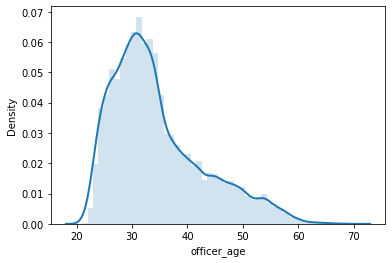

In [69]:
sns.distplot(df['officer_age'], kde_kws={'lw':2}, hist_kws={'alpha':.2})

## What are the races of the officers that made the Terry Stop?

,officer_race_pct,seattle_police
officer_race,,
American Indian/Alaska Native,0.006391,NaN
Asian,0.043654,0.086
Black or African American,0.038867,0.086
Hispanic or Latino,0.058300,0.052
Nat Hawaiian/Oth Pac Islander,0.009467,NaN
Not Specified,0.034642,NaN
Two or More Races,0.058386,NaN
White,0.750292,0.753


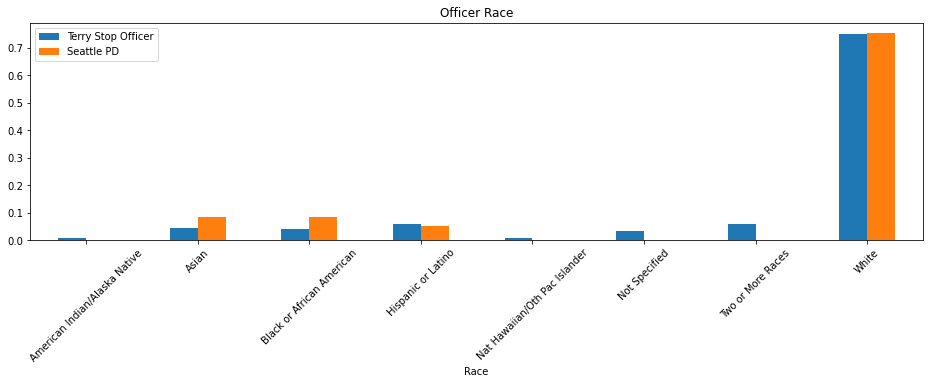

In [70]:
#subset the data
tmp = df[['officer_race','count']]
tmp = tmp.groupby('officer_race')[['count']].count()

#create dataframe with demographics of the Seattle Police Force
#https://www.governing.com/gov-data/safety-justice/police-department-officer-demographics-minority-representation.html
police_race = pd.DataFrame(index = ['White', 'Hispanic or Latino',
                                    'Black or African American', 'Asian'],
                           data = {'seattle_police' : [.753,.052,.086,.086]} )

#generate officer race percentage
tmp['officer_race_pct'] = tmp['count'] / int(tmp.sum())

tmp.drop(['count'], inplace = True, axis = 1) # drop original columns

tmp = tmp.join(police_race)                   #join both dataframes together

#create plot
tmp.plot(kind = 'bar', figsize = (16, 4))
_plt.xticks(rotation = 45)
plt.title('Officer Race')
plt.xlabel('Race')
plt.legend(loc = 'best', labels = ['Terry Stop Officer', 'Seattle PD'] )
tmp

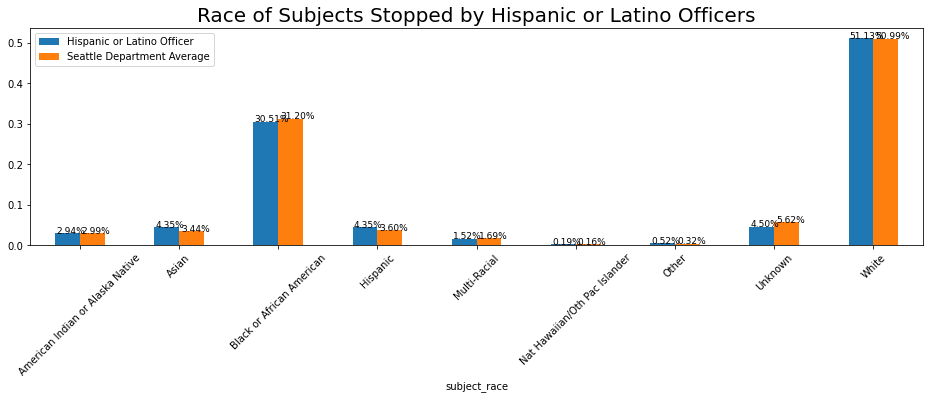

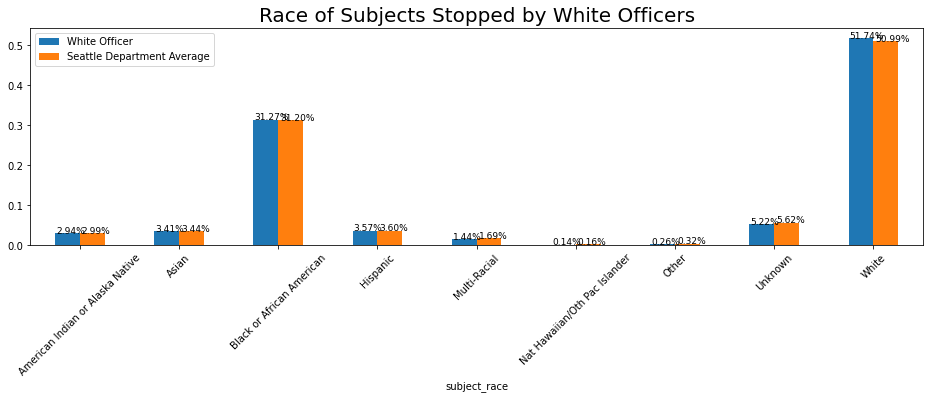

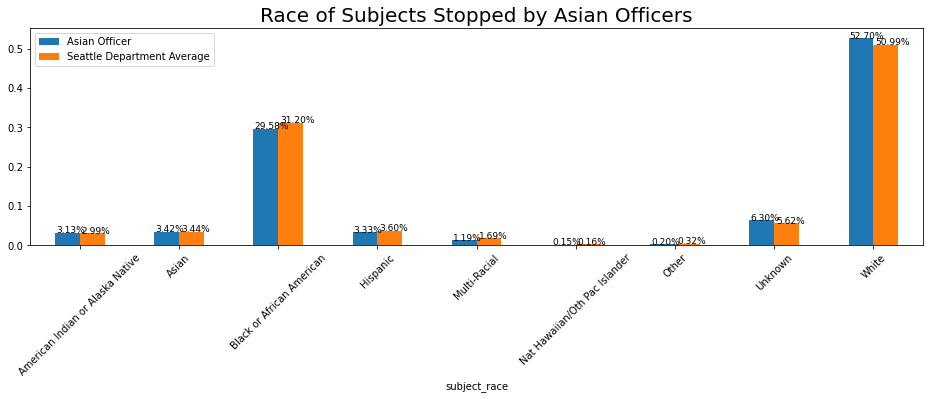

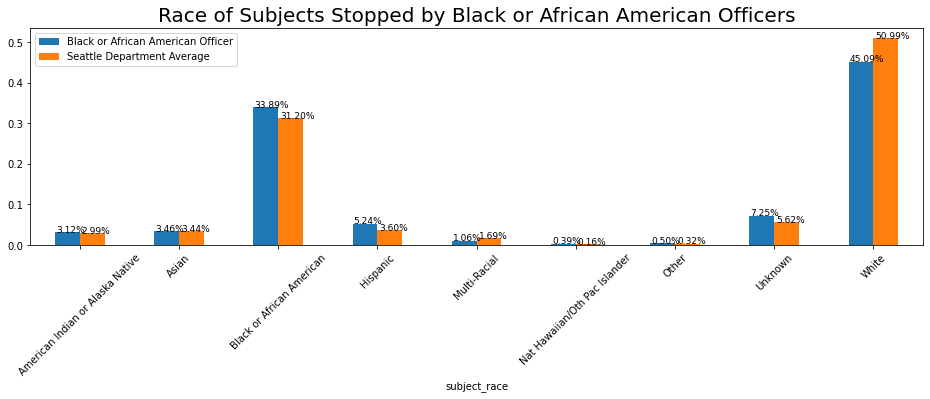

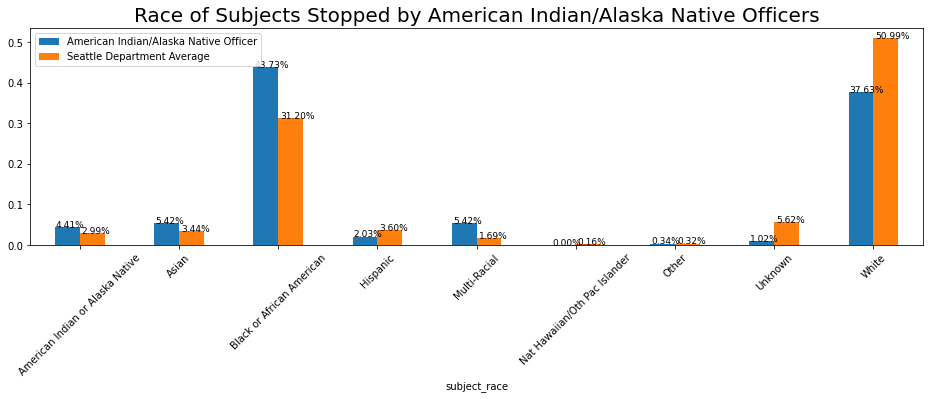

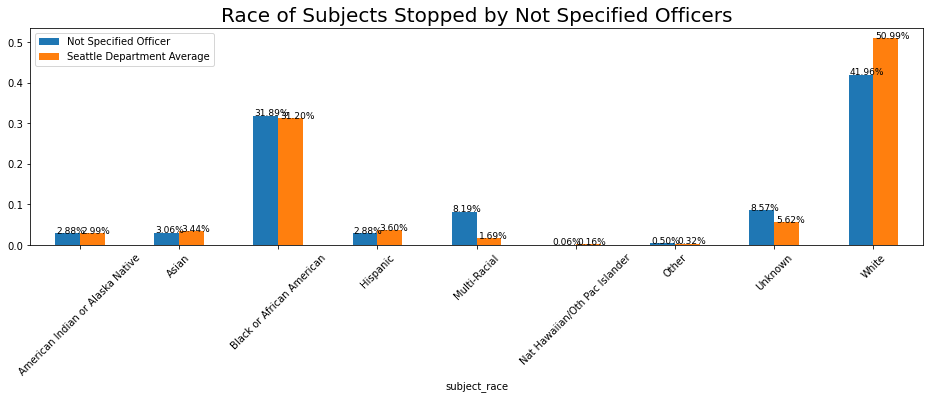

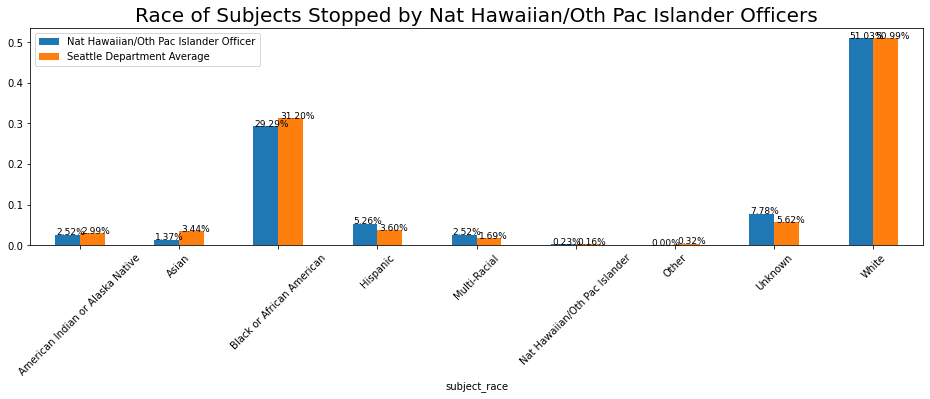

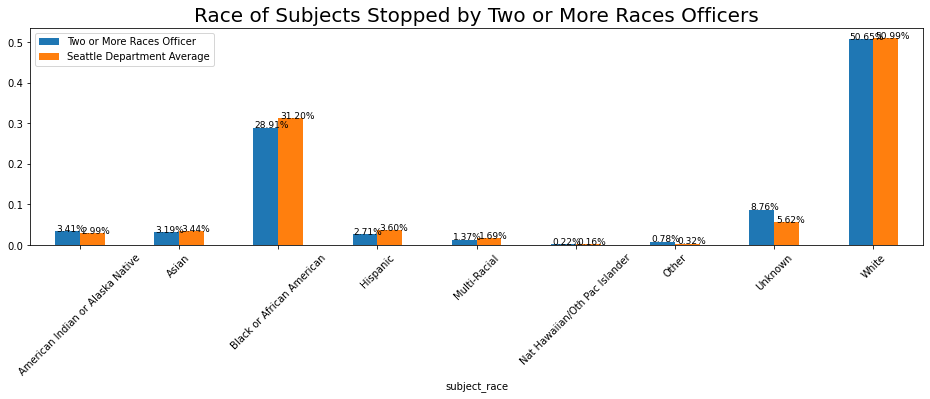

In [71]:
#subset the data
dataframe = df[['officer_race','subject_race','count']]

officer_races = list(df.officer_race.unique()) #obtain a list of all the officer races

officer_list = dict() # empty dictionary to hold each filtered dataframe

#create dataframes for each race
for race in officer_races:
    po_race = dataframe[dataframe.officer_race == race]
    po_race = po_race.groupby('subject_race').count()
    po_race['stop_pct'] = po_race['count'] / po_race['count'].sum()
    po_race.drop(['count', 'officer_race'], axis = 1, inplace = True)
    officer_list[race] = po_race

#create seperate dataframe for department average numbers
tmp = df[['subject_race','count']]
tmp = tmp.groupby('subject_race').count()
tmp['stop_pct'] = tmp['count'] / tmp['count'].sum()
tmp.drop(['count'], axis = 1, inplace = True)
  
#display the plots
for ttl, df in officer_list.items():
    ax = pd.merge(df, tmp, left_index = True, right_index = True).plot(kind = 'bar', figsize = (16,4))
    plt.title('Race of Subjects Stopped by {} Officers'.format(ttl), fontsize = 20)
    plt.legend(labels = [ttl+' Officer', 'Seattle Department Average'] )
    plt.xticks(rotation = 45)
    
    #generate text values above the columns
    for i, v in enumerate(df.stop_pct):
        ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )
    
    for i, v in enumerate(tmp.stop_pct):
        ax.text(i+.02, v, '{:.2f}%'.format(100*v),fontsize = 9 )